In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np

In [11]:
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWC/user.csv')
users = users.drop(['Unnamed: 0'], axis = 1)

In [12]:
music = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWC/music.csv')
music = music.drop(['Unnamed: 0'], axis = 1)
music = music.dropna(axis = 0)

In [13]:
import re

lyricc = []
for i in music['lyric']:
  lyric = re.sub(' +', ' ', i)
  lyricc.append(lyric[:-1])

music['lyric'] = lyricc

In [14]:
music = music.reset_index(drop = True)

In [15]:
audio_feature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SWC/audio_feature.csv', sep=',')
audio_feature.drop('Unnamed: 0', axis = 1, inplace = True)

In [16]:
aa = audio_feature[['song_ids']]
musicp = pd.merge(aa, music)
musicp

,song_ids,song_titles,song_durations,artist_names,song_tempo,track_id,mxm_track_id,lyric
0,SOPXNHL12A58A79B0F,Need,204.59057,Tyrone Wells,159.900,TRBGRWH128F92E3551,5725860,I don't love you baby Don't love you at all I ...
1,SOMCFYL12A81C239F0,Again (Instrumental),232.20200,Janet Jackson,130.229,TRBGOAU128F4255BDA,2286179,I heard from a friend today And she said you w...
2,SOWICJC12A6D4F918D,Palavras,233.24689,Nana Caymmi,99.133,TRBGTNZ128F1481BBD,3946639,"Palavras, palavras, palavras Eu já não aguento..."
3,SOTMVUQ12A6BD53721,Nothing To Hold Me,201.16853,Jesus Jones,66.246,TRBGTZD128EF34B6C3,1619358,I changed my name and you changed your mind Th...
4,SOCVUYU12A67AE217D,Locked Away,203.49342,The Gathering,91.003,TRBGFXC12903D01967,862612,If I got locked away And we lost it all today ...
...,...,...,...,...,...,...,...,...
1479,SOEKYVZ12AB018741A,Please Hammer Don't Hurt 'Em,143.88200,Evergreen Terrace,166.030,TRALPGW12903CAFFB5,1445049,I hope I never give up. So afraid I'll break t...
1480,SOESQNH12A58A79AC3,Pretty Vacant,194.58567,Sex Pistols,144.573,TRALPXC128E07819A8,6881062,There's no point in asking You'll get no reply...
1481,SOFPTCN12A8C13BD3C,Ruta Del Coya,266.76200,León Gieco,120.023,TRALPOE128F4272278,849559,Dios sol Dios agua Que cae del cielo gris Al a...
1482,SOOCYRU12A8C132403,Lachen und weinen,335.17669,2raumwohnung,111.016,TRALPQV128F424F989,2787696,Wenn ich glücklich bin Und der himmel in meine...


## 가사 기반 추천시스템

### Tf-idf



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer = 'word', stop_words = 'english')

tfidf_matrix = tfidf.fit_transform(musicp['lyric'])

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(tfidf_matrix)

similarities = {}
for i in range(len(cosine_similarities)):
  similar_indices = cosine_similarities[i].argsort()[:50:-1]
  similarities[musicp['song_titles'].iloc[i]]=[(cosine_similarities[i][x], musicp['song_titles'][x], musicp['artist_names'][x], musicp['song_ids'][x]) for x in similar_indices][1:]

In [19]:
class TFIDFRecommender:
  def __init__(self, matrix):
    self.matrix_similar = matrix
  def _print_message(self, song, recom_song):
    rec_items = len(recom_song)
    print(f'The {rec_items} recommended songs for {song} are:')
    for i in range(rec_items):
      print(f"Number {i+1}:")
      print(f"{recom_song[i][1]} by {recom_song[i][2]} with {round(recom_song[i][0], 3)} similarity score")
      print("----------------------------")
  def recommend(self, recommendation):
    song = recommendation['song']
    number_songs = recommendation['number_songs']
    recom_song = self.matrix_similar[song][:number_songs]
    rec = []
    for i in range(len(recom_song)):
      rec.append(recom_song[i][3])
    return rec
  def print(self, recommendation):
    song = recommendation['song']
    number_songs = recommendation['number_songs']
    recom_song = self.matrix_similar[song][:number_songs]
    self._print_message(song = song, recom_song = recom_song)

In [20]:
tfidf_recommend = TFIDFRecommender(similarities)
recommendation10 = {"song" : musicp['song_titles'].iloc[0], "number_songs":10}
rec = tfidf_recommend.recommend(recommendation10)
tfidf_recommend.print(recommendation10)

The 10 recommended songs for Need are:
Number 1:
Baby Don't You Change by Tyrone Wells with 0.424 similarity score
----------------------------
Number 2:
She Don't Move Me No More by BB King with 0.407 similarity score
----------------------------
Number 3:
Are You Ever Gonna Love Me? by Jimmy Wayne with 0.324 similarity score
----------------------------
Number 4:
Forever by VHS Or Beta with 0.296 similarity score
----------------------------
Number 5:
They Say (Album) by Jupiter Rising with 0.291 similarity score
----------------------------
Number 6:
Need (LP Version) by Cindy Morgan with 0.287 similarity score
----------------------------
Number 7:
Say Say Say (Waiting 4 U) (Tocadisco's Not Guilty Remix) by Hi-Tack with 0.262 similarity score
----------------------------
Number 8:
Last Hope's Gone (LP Version ) by The Paul Butterfield Blues Band with 0.262 similarity score
----------------------------
Number 9:
The Hotness (ft. Shontelle) by Rihanna with 0.259 similarity score
----

In [21]:
def tfidf_recall(num):
  count_list = []
  for i in range(len(musicp)):
    recommendation = {"song" : musicp['song_titles'].iloc[i], "number_songs":num}
    rec = tfidf_recommend.recommend(recommendation)
    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    count_list.append(count)

  return sum(count_list)/len(musicp)

In [ ]:
tfidf_recall10 = tfidf_recall(10)
print(tfidf_recall10)

0.011409395973154362


In [ ]:
tfidf_recall50 = tfidf_recall(50)
print(tfidf_recall50)

0.053020134228187916


In [ ]:
dcg_list = []
idcg_list = []
for i in range(len(musicp)):
  recommendation100 = {"song" : musicp['song_titles'].iloc[i], "number_songs":100}
  rec = tfidf_recommend.recommend(recommendation100)
  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  dcg_list.append(dcg_)
  idcg_list.append(idcg_)

dcg = sum(dcg_list)/len(music)
idcg = sum(idcg_list)/len(music)
print(dcg/idcg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.17884051249657523


#### PCA 적용한 Tf-idf

In [22]:
tfidf_array = tfidf_matrix.toarray()
tfidf_array.shape

(1484, 13224)

In [23]:
from sklearn.decomposition import PCA
NUM_COMPONENTS = 1300
pca = PCA(NUM_COMPONENTS)
reduced = pca.fit_transform(tfidf_array)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

pca_cosine_similarities = cosine_similarity(reduced)

pca_similarities = {}
for i in range(len(pca_cosine_similarities)):
  similar_indices = pca_cosine_similarities[i].argsort()[:50:-1]
  pca_similarities[musicp['song_titles'].iloc[i]]=[(pca_cosine_similarities[i][x], musicp['song_titles'][x], musicp['artist_names'][x], musicp['song_ids'][x]) for x in similar_indices][1:]

In [25]:
pca_tfidf_recommend = TFIDFRecommender(pca_similarities)
pca_recommendation10 = {"song" : musicp['song_titles'].iloc[0], "number_songs":10}
pca_rec = pca_tfidf_recommend.recommend(pca_recommendation10)
pca_tfidf_recommend.print(pca_recommendation10)

The 10 recommended songs for Need are:
Number 1:
She Don't Move Me No More by BB King with 0.455 similarity score
----------------------------
Number 2:
Baby Don't You Change by Tyrone Wells with 0.449 similarity score
----------------------------
Number 3:
Are You Ever Gonna Love Me? by Jimmy Wayne with 0.329 similarity score
----------------------------
Number 4:
Forever by VHS Or Beta with 0.312 similarity score
----------------------------
Number 5:
They Say (Album) by Jupiter Rising with 0.297 similarity score
----------------------------
Number 6:
Need (LP Version) by Cindy Morgan with 0.296 similarity score
----------------------------
Number 7:
Say Say Say (Waiting 4 U) (Tocadisco's Not Guilty Remix) by Hi-Tack with 0.279 similarity score
----------------------------
Number 8:
Last Hope's Gone (LP Version ) by The Paul Butterfield Blues Band with 0.257 similarity score
----------------------------
Number 9:
WHEN I AM YOU by Panzer AG with 0.256 similarity score
----------------

In [26]:
def pca_tfidf_recall(num):
  pca_count_list = []
  for i in range(len(musicp)):
    recommendation = {"song" : musicp['song_titles'].iloc[i], "number_songs":num}
    rec = pca_tfidf_recommend.recommend(recommendation)
    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    pca_count_list.append(count)

  return sum(pca_count_list)/len(musicp)

In [ ]:
pca_tfidf_recall10 = pca_tfidf_recall(10)
print(pca_tfidf_recall10)

0.013422818791946308


In [ ]:
pca_tfidf_recall50 = pca_tfidf_recall(50)
print(pca_tfidf_recall50)

0.05771812080536913


In [ ]:
pca_dcg_list = []
pca_idcg_list = []
for i in range(len(musicp)):
  recommendation100 = {"song" : musicp['song_titles'].iloc[i], "number_songs":100}
  rec = pca_tfidf_recommend.recommend(recommendation100)
  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  pca_dcg_list.append(dcg_)
  idcg_list.append(idcg_)

pca_dcg = sum(pca_dcg_list)/len(musicp)
pca_idcg = sum(pca_idcg_list)/len(musicp)
ndcg_pca_tfidf = pca_dcg/pca_idcg
print(ndcg_pca_tfidf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.1864451090750194


### Word2Vec

In [28]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

corpus = []
for words in musicp['lyric']:
    corpus.append(words.split())

word2vec_model = Word2Vec(size = 300, window=5, min_count = 2)
word2vec_model.build_vocab(corpus)
file_name = '/content/drive/MyDrive/Colab Notebooks/SWC/GoogleNews-vectors-negative300.bin'
word2vec_model.intersect_word2vec_format(fname = file_name, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(1275838, 1773675)

In [29]:
def get_document_vectors(document_list):
    document_embedding_list = []

    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    return document_embedding_list

In [30]:
document_embedding_list = get_document_vectors(musicp['lyric'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities_w2v = cosine_similarity(document_embedding_list, document_embedding_list)

In [32]:
def recommendations(index, rec_items):

    sim_scores = list(enumerate(cosine_similarities_w2v[index]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:(rec_items+1)]

    song_indices = [i[0] for i in sim_scores]

    return song_indices, sim_scores

In [33]:
def print_recommend(index, rec_items, song_indices, sim_scores):
    title = musicp.iloc[index]['song_titles']

    print(f'The {rec_items} recommended songs for {title} are:')
    for i in range(rec_items):
      print(f"Number {i+1}:")
      idx = song_indices[i]
      print(f"{musicp.iloc[idx]['song_titles']} by {musicp.iloc[idx]['artist_names']} with {round(sim_scores[i][1], 3)} similarity score")
      print("----------------------------")

In [34]:
music_indices, w2v_sim_scores = recommendations(0, 10)
print_recommend(0, 10, music_indices, w2v_sim_scores)

The 10 recommended songs for Need are:
Number 1:
They Say (Album) by Jupiter Rising with 0.9449999928474426 similarity score
----------------------------
Number 2:
Teasin' Brown by North Mississippi Allstars with 0.9390000104904175 similarity score
----------------------------
Number 3:
Romantic Rights (Jesper Dahlback Remix) by Death From Above 1979 with 0.9390000104904175 similarity score
----------------------------
Number 4:
Left To Starve by Eyehategod with 0.9390000104904175 similarity score
----------------------------
Number 5:
Miss Ohio's Nameless by Why? with 0.9380000233650208 similarity score
----------------------------
Number 6:
Hummingbird by Jimmy Page with 0.9380000233650208 similarity score
----------------------------
Number 7:
Fortress by Tim Exile with 0.9369999766349792 similarity score
----------------------------
Number 8:
Heart Trouble by Martina McBride with 0.9359999895095825 similarity score
----------------------------
Number 9:
They Reminisce Over You (Sin

In [35]:
def w2v_reacll(num):
  w2v_count_list = []
  for i in range(len(document_embedding_list)):
    rec_indices, rec_sim = recommendations(i, num)
    rec = []
    for i in range(num):
      rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    w2v_count_list.append(count)

  return sum(w2v_count_list)/len(document_embedding_list)

In [ ]:
w2v_recall10 = w2v_recall(10)
print(w2v_recall10)

0.00202020202020202


In [ ]:
w2v_recall50 = w2v_recall(50)
print(w2v_recall50)

0.2026936026936027


In [ ]:
w2v_dcg_list = []
w2v_idcg_list = []
for i in range(len(document_embedding_list)):
  rec_indices, rec_sim = recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  w2v_dcg_list.append(dcg_)
  w2v_idcg_list.append(idcg_)

w2v_dcg = sum(w2v_dcg_list)/len(document_embedding_list)
w2v_idcg = sum(w2v_idcg_list)/len(document_embedding_list)
ndcg_w2v = w2v_dcg/w2v_idcg
print(ndcg_w2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.06956592432583182


### BERT

In [36]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 4.2 MB 36.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.4 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 6.6 MB 40.8 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=f2d8f6394dbb443d14d998a9994b351613dd831a5f7017080054ed4096c9d603
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [37]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [38]:
sentence_embeddings = bert.encode(musicp['lyric'].tolist())

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities_bert = cosine_similarity(sentence_embeddings)

In [40]:
def bert_recommendations(index, rec_items):

    sim_scores = list(enumerate(cosine_similarities_bert[index]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:(rec_items+1)]

    song_indices = [i[0] for i in sim_scores]

    return song_indices, sim_scores

In [41]:
bert_music_indices, bert_sim_scores = bert_recommendations(0, 10)
print_recommend(0, 10, bert_music_indices, bert_sim_scores)

The 10 recommended songs for Need are:
Number 1:
Heart Trouble by Martina McBride with 0.875 similarity score
----------------------------
Number 2:
Medicine by Bobaflex with 0.8519999980926514 similarity score
----------------------------
Number 3:
I Want To Know You More by Scott Krippayne with 0.8429999947547913 similarity score
----------------------------
Number 4:
They Say (Album) by Jupiter Rising with 0.8349999785423279 similarity score
----------------------------
Number 5:
Telling Me Lies by Dolores Keane with 0.8330000042915344 similarity score
----------------------------
Number 6:
Control It (Album Version) by Static-X with 0.8309999704360962 similarity score
----------------------------
Number 7:
----------------------------
Number 8:
Savin' Me by Nickelback with 0.8299999833106995 similarity score
----------------------------
Number 9:
V by Zeromancer with 0.8270000219345093 similarity score
----------------------------
Number 10:
Mirror (Album) by Cinder with 0.82300001

In [ ]:
def bert_recall(num):
  bert_count_list = []
  for i in range(len(musicp)):
    rec_indices, rec_sim = bert_recommendations(i, num)
    rec = []
    for i in range(num):
      rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    bert_count_list.append(count)

  return sum(bert_count_list)/len(musicp)

In [ ]:
bert_recall10 = bert_recall(10)
print(bert_recall10)

0.003355704697986577


In [ ]:
bert_recall50 = bert_recall(50)
print(bert_recall50)

0.0953020134228188


In [ ]:
dcg_list_bert = []
idcg_list_bert = []
for i in range(len(musicp)):
  rec_indices, rec_sim = bert_recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  dcg_list_bert.append(dcg_)
  idcg_list_bert.append(idcg_)

dcg_bert = np.array(dcg_list_bert)
idcg_bert = np.array(idcg_list_bert)
ndcg_bert = dcg_bert/idcg_bert
ndcg_bert = np.mean(ndcg_bert)
print(ndcg_bert)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.10969019481247368


In [ ]:
import seaborn as sns

data = {'recall@10' : [pca_tfidf_recall10, w2v_recall10, bert_recall10],
        'recall@50' : [pca_tfidf_recall50, w2v_recall50, bert_recall50],
        'nDCG_100' : [ndcg_pca_tfidf, ndcg_w2v, ndcg_bert]}

result = pd.DataFrame(data)
result.index = ['PCA_tfidf', 'Word2vec', 'BERT']

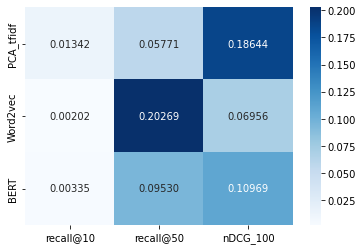

In [ ]:
re_heat = sns.heatmap(result, annot = True, fmt = '.5f', cmap = 'Blues')

---

각 모델들을 결합해 가장 높은 성능의 가사 기반 추천시스템 구축

### Tf-idf + BERT

In [42]:
def tfidf_bert_recommendations(index, rec_items):

    tfidf_sim_scores = list(enumerate(pca_cosine_similarities[index]))
    bert_sim_scores = list(enumerate(cosine_similarities_bert[index]))
    
    total_score = []

    for i in range(len(tfidf_sim_scores)):
      tfidf_score = tfidf_sim_scores[i][1]
      bert_score = bert_sim_scores[i][1]
      score = tfidf_score*0.5+bert_score*0.5
      total_score.append((i, score))

    total_scores = sorted(total_score, key = lambda x: x[1], reverse = True)
    total_scores = total_scores[1:(rec_items+1)]

    song_indices = [i[0] for i in total_scores]

    return song_indices, total_scores

In [ ]:
def tfidf_bert_recall(num):
  tfidf_bert_count_list = []
  for i in range(len(musicp)):
    rec_indices, rec_sim = tfidf_bert_recommendations(i, num)
    rec = []
    for i in range(num):
      rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

    title = music['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    tfidf_bert_count_list.append(count)

  return sum(tfidf_bert_count_list)/len(musicp)

In [ ]:
tfidf_bert_recall10 = tfidf_bert_recall(10)
print(tfidf_bert_recall10)

0.0087248322147651


In [ ]:
tfidf_bert_recall50 = tfidf_bert_recall(50)
print(tfidf_bert_recall50)

0.08322147651006712


In [ ]:
tfidf_bert_dcg_list = []
tfidf_bert_idcg_list = []
for i in range(len(musicp)):
  rec_indices, rec_sim = tfidf_bert_recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  tfidf_bert_dcg_list.append(dcg_)
  tfidf_bert_idcg_list.append(idcg_)

tfidf_bert_dcg = sum(tfidf_bert_dcg_list)/len(musicp)
tfidf_bert_idcg = sum(tfidf_bert_idcg_list)/len(musicp)
ndcg_tfidf_bert = tfidf_bert_dcg/tfidf_bert_idcg
print(ndcg_tfidf_bert)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.12107313955716366


### Word2Vec + BERT

In [ ]:
#w2v 7 : bert 3
def w2v_bert_recommendations(index, rec_items):

    w2v_sim_scores = list(enumerate(cosine_similarities_w2v[index]))
    bert_sim_scores = list(enumerate(cosine_similarities_bert[index]))

    total_score = []

    for i in range(len(w2v_sim_scores)):
      w2v_score = w2v_sim_scores[i][1]
      bert_score = bert_sim_scores[i][1]
      score = w2v_score*0.7+bert_score*0.3
      total_score.append((i, score))

    total_scores = sorted(total_score, key = lambda x: x[1], reverse = True)
    total_scores = total_scores[1:(rec_items+1)]

    song_indices = [i[0] for i in total_scores]

    return song_indices, total_scores

In [ ]:
def w2v_bert_recall(num):
  w2v_bert_count_list = []
  for i in range(len(document_embedding_list)):
    rec_indices, rec_sim = w2v_bert_recommendations(i, num)
    rec = []
    for i in range(num):
      rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    w2v_bert_count_list.append(count)

  return sum(w2v_bert_count_list)/len(document_embedding_list)

In [ ]:
w2v_bert_recall10 = w2v_bert_recall(10)
print(w2v_bert_recall10)

0.0006734006734006734


In [ ]:
w2v_bert_recall50 = w2v_bert_recall(50)
print(w2v_bert_recall50)

0.1367003367003367


In [ ]:
w2v_bert_dcg_list = []
w2v_bert_idcg_list = []
for i in range(len(document_embedding_list)):
  rec_indices, rec_sim = w2v_bert_recommendations(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  w2v_bert_dcg_list.append(dcg_)
  w2v_bert_idcg_list.append(idcg_)

w2v_bert_dcg = sum(w2v_bert_dcg_list)/len(document_embedding_list)
w2v_bert_idcg = sum(w2v_bert_idcg_list)/len(document_embedding_list)
ndcg_w2v_bert = w2v_bert_dcg/w2v_bert_idcg
print(ndcg_w2v_bert)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.14639993029764609


In [ ]:
# w2v 8 + bert 2
def w2v_bert_recommendations82(index, rec_items):

    w2v_sim_scores = list(enumerate(cosine_similarities_w2v[index]))
    bert_sim_scores = list(enumerate(cosine_similarities_bert[index]))

    total_score = []

    for i in range(len(w2v_sim_scores)):
      w2v_score = w2v_sim_scores[i][1]
      bert_score = bert_sim_scores[i][1]
      score = w2v_score*0.8+bert_score*0.2
      total_score.append((i, score))

    total_scores = sorted(total_score, key = lambda x: x[1], reverse = True)
    total_scores = total_scores[1:(rec_items+1)]

    song_indices = [i[0] for i in total_scores]

    return song_indices, total_scores

In [ ]:
def w2v_bert82_recall(num):
  w2v_bert_count_list = []
  for i in range(len(document_embedding_list)):
    rec_indices, rec_sim = w2v_bert_recommendations82(i, num)
    rec = []
    for i in range(num):
      rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

    title = musicp['song_ids'].iloc[i]
    title_user = users[users['song_ids'] == title]
    if len(title_user) != 0:
      max_user = title_user['play_count'].idxmax()
      max_user = title_user.loc[max_user]
      max_user_id = max_user['user_id']
      user_0 = users[users['user_id'] == max_user_id]
      user_0 = user_0.sort_values('play_count', ascending = False)
      user_list = list(user_0['song_ids'][:num])
      count = 0
      for i in rec:
        for j in user_list:
          if i == j:
            count += 1
    else:
      count = 0
    w2v_bert_count_list.append(count)

  return sum(w2v_bert_count_list)/len(document_embedding_list)

In [ ]:
w2v_bert82_recall10 = w2v_bert82_recall(10)
print(w2v_bert82_recall10)

0.0


In [ ]:
w2v_bert82_recall50 = w2v_bert82_recall(50)
print(w2v_bert82_recall50)

0.16026936026936026


In [ ]:
w2v_bert_dcg_list82 = []
w2v_bert_idcg_list82 = []
for i in range(len(document_embedding_list)):
  rec_indices, rec_sim = w2v_bert_recommendations82(i, 100)
  rec = []
  for i in range(100):
    rec.append(musicp.iloc[rec_indices[i]]['song_ids'])

  title = musicp['song_ids'].iloc[i]
  title_user = users[users['song_ids'] == title]
  if len(title_user) != 0:
    max_user = title_user['play_count'].idxmax()
    max_user = title_user.loc[max_user]
    max_user_id = max_user['user_id']
    user_0 = users[users['user_id'] == max_user_id]
    relevant = []
    for j in range(len(user_0)):
      play = user_0.iloc[j]['play_count']
      if play >= 2 and play <= 5:
        relevant.append(2)
      elif play > 5:
        relevant.append(3)
      elif play < 2:
        relevant.append(1)
    user_0['relevant'] = relevant
    user_0 = user_0.sort_values('play_count', ascending = False)
    user_0 = user_0.reset_index(drop = True)
    user_list = list(user_0['song_ids'])
    dcg_ = 0
    idcg_ = 0
    for k in range(len(user_0)):
      for i in rec:
        for j in user_list:
          if i == j:
            idx = user_0[user_0['song_ids'] == j].index[0]
            dcg_ += (user_0.iloc[idx]['relevant']/np.log2(k+2))
      if k < 100:
        idcg_ += (user_0.iloc[k]['relevant']/np.log2(k+2))
  w2v_bert_dcg_list82.append(dcg_)
  w2v_bert_idcg_list82.append(idcg_)

w2v_bert_dcg82 = sum(w2v_bert_dcg_list82)/len(document_embedding_list)
w2v_bert_idcg82 = sum(w2v_bert_idcg_list82)/len(document_embedding_list)
ndcg_w2v_bert82 = w2v_bert_dcg82/w2v_bert_idcg82
print(ndcg_w2v_bert82)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.1474382276756436


In [ ]:
import seaborn as sns

data = {'recall@10' : [tfidf_bert_recall10, w2v_bert_recall10, w2v_bert82_recall10],
        'recall@50' : [tfidf_bert_recall50, w2v_bert_recall50, w2v_bert82_recall50],
        'nDCG_100' : [ndcg_tfidf_bert, ndcg_w2v_bert, ndcg_w2v_bert82]}

result = pd.DataFrame(data)
result.index = ['tfidf+bert', 'w2v7+bert3', 'w2v8+bert2']

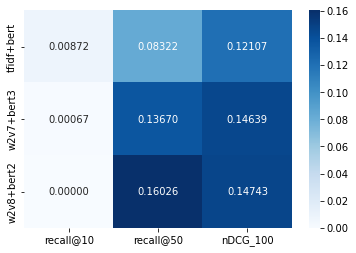

In [ ]:
re_heat = sns.heatmap(result, annot = True, fmt = '.5f', cmap = 'Blues')